# DEA Intertidal Elevation

This notebook demonstrates how to run and customise a DEA Intertidal Elevation analysis.

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install -r requirements.in --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import os
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
import odc.geo.xr
from odc.geo.geom import Geometry
from odc.geo.geobox import GeoBox
from odc.ui import select_on_a_map
from dea_tools.dask import create_local_dask_cluster

from intertidal.tide_modelling import pixel_tides_ensemble
from intertidal.io import load_data, load_topobathy_mask, prepare_for_export
from intertidal.elevation import (
    ds_to_flat,
    pixel_rolling_median,
    pixel_dem,
    pixel_dem_debug,
    pixel_uncertainty,
    flat_to_ds,
    clean_edge_pixels,
    elevation,
)

## Setup


### Set analysis parameters

In [3]:
# Intertidal Elevation variables
start_date = "2020"  # Start date for analysis
end_date = "2022"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model = "ensemble"  # Tide model to use in analysis 
# tide_model_dir = "/var/share/tide_models"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
tide_model_dir = "/gdata1/data/tide_models_clipped"

#### Set study area

##### Option 1: load study area from 32 km tile GridSpec

In [4]:
# # Set study area (e.g. tile ID in form "x094y145")
# study_area = "x094y145"
# geom = None  # Use GridSpec to load study area, not a custom geom

##### Option 2: load study area from vector file

In [5]:
# # Set study area to load from file
# study_area = "pointstuart"

# # Read file, select study area and convert to geom
# studyarea_gdf = gpd.read_file(
#     "data/raw/intertidal_development_polygons.geojson"
# ).set_index("id")
# geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
# geom

##### Option 3: load study area using interactive map

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

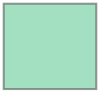

In [6]:
# Set study area name for outputs
study_area = "testing"

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
geom

## Load data

In [7]:
%%time

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds, _, _ = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=True,
    filter_gqa=filter_gqa,
    max_cloudcover=90,
    skip_broken_datasets=True,
)

print(satellite_ds)

# Load data
satellite_ds.load()


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41033,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:40093,Total threads: 31
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/40695/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:37443,


<xarray.Dataset>
Dimensions:      (time: 306, y: 486, x: 538)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-02T00:57:27.736492 ... 2022-12...
  * y            (y) float64 -1.284e+06 -1.284e+06 ... -1.289e+06 -1.289e+06
  * x            (x) float64 -1.508e+04 -1.506e+04 ... -9.715e+03 -9.705e+03
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 486, 538), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 7.43 s, sys: 761 ms, total: 8.19 s
Wall time: 54.7 s


<xarray.Dataset>
Dimensions:      (time: 306, y: 486, x: 538)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-02T00:57:27.736492 ... 2022-12...
  * y            (y) float64 -1.284e+06 -1.284e+06 ... -1.289e+06 -1.289e+06
  * x            (x) float64 -1.508e+04 -1.506e+04 ... -9.715e+03 -9.705e+03
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
# # Experiment of removing mostly empty scenes to reduce memory/speed up
# satellite_ds = satellite_ds.sel(
#     time=satellite_ds.ndwi.notnull().mean(dim=["y", "x"]) > 0.9
# )

### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [8]:
# Load data from GA's AusBathyTopo 250m 2023 Grid
topobathy_mask = load_topobathy_mask(
    dc=dc,
    geobox=satellite_ds.odc.geobox.compat,
    product="ga_ausbathytopo250m_2023",
    resampling="bilinear",
    min_threshold=-15,
    mask_filters=[("dilation", 25)],
)

## Pixel-based tides

In [9]:
# Model tides into every pixel in the three-dimensional satellite
# dataset (x by y by time). If `model` is "ensemble" this will model
# tides by combining the best local tide models.
tide_m, _ = pixel_tides_ensemble(
        ds=satellite_ds,
        ancillary_points="data/raw/tide_correlations_2017-2019.geojson",
        top_n=3,
        reduce_method='mean',
        model=tide_model,
        directory=tide_model_dir,
    )

Running ensemble tide modelling
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:19<00:00,  1.79it/s]


Returning low resolution tide array
Generating ensemble tide model from point inputs
                 weights
tide_model              
HAMTIDE11       0.360616
EOT20           0.344405
FES2014         0.341572
TPXO9-atlas-v5  0.334541
GOT4.10         0.329943
TPXO8-atlas-v1  0.320947
FES2012         0.313632
Reducing multiple model outputs using 'mean'
Reprojecting tides into original array


In [10]:
## Experimental: testing ebb flow filtering
# ebb_flow_da, tide_m_offset = pixel_ebb_flow(tide_m, offset_min=15)

In [11]:
# Set tide array pixels to nodata if the satellite data array pixels contain
# nodata. This ensures that we ignore any tide observations where we don't
# have matching satellite imagery
satellite_ds["tide_m"] = tide_m.where(
    ~satellite_ds.to_array().isel(variable=0).isnull().drop("variable")
)

## Pixel-based DEM creation

### Flatten array from 3D to 2D and drop pixels with no correlation with tide
Flatten array to only pixels with positive correlations between water observations and tide height. This greatly improves processing time by ensuring only a narrow strip of pixels along the coastline are analysed, rather than the entire x * y array:


![](../data/figures/tide_array_flattening.JPG)

In [12]:
%%time
flat_ds, freq, corr = ds_to_flat(
    satellite_ds,
    ndwi_thresh=0.0,
    min_freq=0.01,
    max_freq=0.99,
    min_correlation=0.15,
    valid_mask=topobathy_mask,
)

Reducing analysed pixels from 261468 to 74374 (28.44%)
CPU times: user 1.95 s, sys: 1.21 s, total: 3.16 s
Wall time: 3.03 s


### Pixel-wise rolling median
This function performs a rolling median calculation along the tide heights of our satellite images. 
It breaks our tide range into `windows_n` individual rolling windows, each of which covers `windows_prop_tide` of the full tidal range. 
For each window, the function returns the median of all tide heights and NDWI index values within the window, and returns an array with a new "interval" dimension that summarises these values from low to high tide.

In [13]:
%%time
interval_ds = pixel_rolling_median(
    flat_ds,
    windows_n=100,
    window_prop_tide=0.15,
    max_workers=None,
    min_count=5,
)

  0%|          | 0/105 [00:00<?, ?it/s]

CPU times: user 13.3 s, sys: 22.5 s, total: 35.8 s
Wall time: 51.3 s


### Model intertidal elevation and uncertainty

Test our workflow by plotting an example elevation extraction for a single pixel:

Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


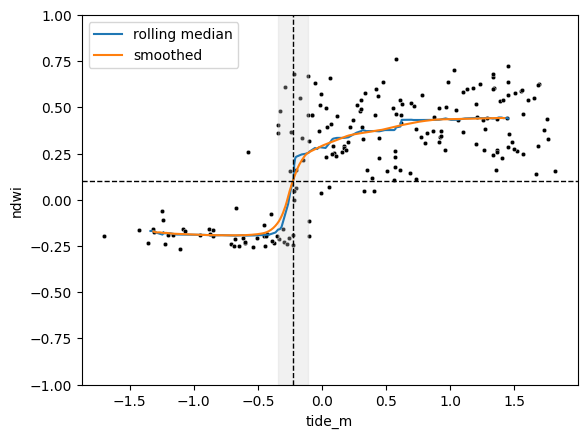

In [14]:
x, y = -12845.7,-1287223.4
interval_pixel, interval_smoothed_pixel = pixel_dem_debug(
    x,
    y,
    flat_ds,
    interval_ds, 
    interp_intervals=200,
    smooth_radius=20,
    min_periods=5,
    # plot_style="season"
)

Now model our full elevation raster:

In [15]:
# Model elevation
flat_dem = pixel_dem(
    interval_ds,
    ndwi_thresh=ndwi_thresh,
    interp_intervals=200,
    smooth_radius=20,
    min_periods=5,
)

Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


In [16]:
# Model uncertainty
low, high, uncertainty, misclassified = pixel_uncertainty(
    flat_ds, flat_dem, ndwi_thresh, method="mad"
)

# Add arrays to dataset
flat_dem[["elevation_low", "elevation_high", "elevation_uncertainty"]] = (
    low,
    high,
    uncertainty,
)

## Unstack outputs and export

In [17]:
# Combine QA layers with elevation layers
flat_combined = xr.combine_by_coords(
    [flat_dem,  # DEM data
     freq,  # Frequency
     corr,  # Correlation
    ],
)

# Unstack elevation and uncertainty layers back into their original 
# spatial dimensions
ds = flat_to_ds(flat_combined, satellite_ds)

# Clean upper edge of intertidal zone in elevation layers 
# (likely to be inaccurate edge pixels)
elevation_bands = [d for d in ds.data_vars if "elevation" in d]
ds[elevation_bands] = clean_edge_pixels(ds[elevation_bands])

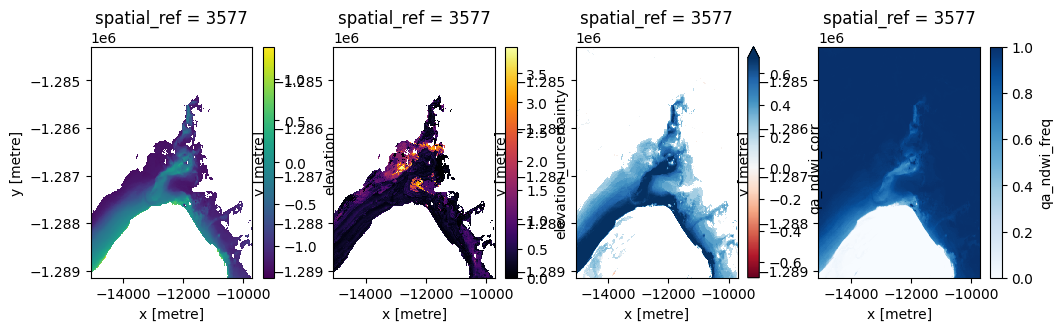

In [18]:
fix, axes = plt.subplots(1, 4, figsize=(12, 3))
ds.elevation.plot.imshow(cmap="viridis", ax=axes[0])
ds.elevation_uncertainty.plot.imshow(cmap="inferno", ax=axes[1])
ds.qa_ndwi_corr.plot.imshow(cmap="RdBu", vmin=-0.7, vmax=0.7, ax=axes[2])
ds.qa_ndwi_freq.plot.imshow(cmap="Blues", vmin=0, vmax=1, ax=axes[3])

In [21]:
ds.elevation.odc.explore()

### Export to GeoTIFF files

In [22]:
# Create output folder if it doesn't exist
output_dir = f"data/interim/{study_area}/{start_date}-{end_date}"
os.makedirs(output_dir, exist_ok=True)

# Prepare data for export
ds["qa_ndwi_freq"] *= 100  # Convert frequency to %

# Prepare for export by correctly setting nodata and dtypes, then
# export to file
ds_prepared = prepare_for_export(ds, output_location=output_dir)

## Close Dask client

In [23]:
client.close()